## 根据已有数据建立一个模型预测给定用户是否会退出银行服务
## Given a Bank customer, can we build a classifier which can determine whether they will leave or not?
数据集来源 Dataset from
https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
all_data = pd.read_csv("../input/Churn_Modelling.csv")

检查数据信息，看上去非常整齐没有缺失  
Check all data info, seems quite well formated and no missing value

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


查看下数据基本情况，可以看出：  
1.Age：最小年龄18岁，最大92岁  
2.Tenure：工作年限最短不到1年，最长10年   
3.CreditScore：每个人目前都给给出了信用分数，最低350，最高850，看上去应该是基于FICO的标准  
4.Balance：账户余额,最少为零，最多25万左右   
5.NumOfProducts：持有银行产品的数量，最少1个，最多4个  
6.HasCrdCard：是否持有信用卡，可看出要么没有信用卡，要么最多只有一张  
7.IsActiveMember：是否活跃用户，看来还是有很多不活跃的用户的  
8.EstimatedSalary: 薪水估计，居然最少是11，谁会拿11块的月薪？  
9.Exited：表示用户是否已经退出，1表示退出，0表示存活 

from the data, we found that:  
1.Age: between 18-92  
2.Tenure:less then one year to 10 years  
3.CreditScore: This score should should be according to FICO standard, it's between 350-850  
4.Balance: 0 - ~250,000  
5.NumOfProduct: Number of product, it's between 1-4  
6.HasCrdCard:Some people have credit card, some don't  
7.IsActiveMember: Whether an user is active or not  
8.EstimatedSalary: it's between 11 - ~200000, who has 11 as salary？  
9.Exited: 1 - exited, 0 - existed  

In [4]:
all_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


看得出来，这里只有三个国家的数据，法国的数据几乎占了一半，德国跟西班牙的数量差不多的  
We can find there are only data for three countries,50% are for France, numbers of Germany and Spain are very close

In [5]:
all_data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

按地域查看退出的情况，德国人的退出率明显高于法国和西班牙，而且不管是哪个国家，女性的退出率高于男性
Check the relationship between country and 'Exited', so German quit more that other countries and from gender perspective, females are more intended to quit

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


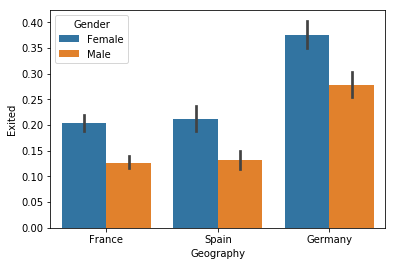

In [6]:
sns.barplot(x='Geography',y='Exited', hue='Gender',data=all_data)

In [7]:
all_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

把Gender数字化，并做独热化处理  
One-hot encoding Gender

In [8]:
dummy_gender = pd.get_dummies(all_data['Gender'], prefix='Gender')

Geography做独热化处理  
One-hot encoding Geography 

In [9]:
dummy_geo = pd.get_dummies(all_data['Geography'],prefix = 'Geo')

NumOfProducts做独热化处理  
One-hot encoding number of products

In [10]:
dummy_NoOfProducts=pd.get_dummies(all_data['NumOfProducts'],prefix='NOP')

查看下随着年龄的变化，退出银行的人数分布    
Check how the number of exited change according to the age

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


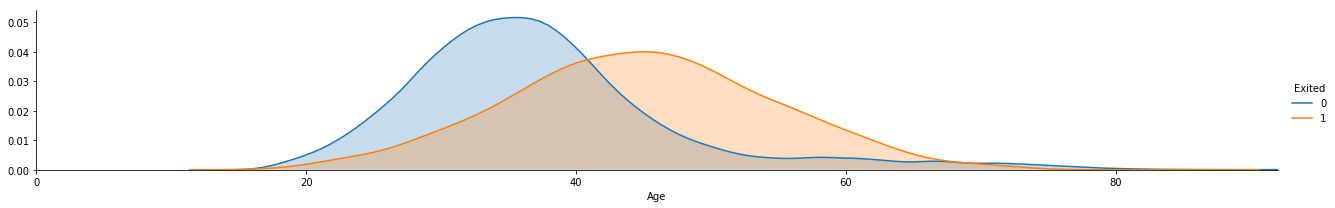

In [11]:
a=sns.FacetGrid(all_data,hue='Exited',aspect=6)
a.map(sns.kdeplot,'Age',shade=True)
a.set(xlim=[0,all_data['Age'].max()])
a.add_legend()

年龄的离散化，分成6段,这个是按照银行内部标准来的  
Split age into 6 section, according to bank starndard

In [12]:
bins = [18,22,34,40,60,80,100]
labels = ['18-22','23-34','35-40','41-60','61-80','81-100']
dummy_age_labels=pd.cut(all_data['Age'],bins,labels=labels,right=False)

In [13]:
all_data['Age_labeled']= dummy_age_labels

每个年龄段持有银行产品数量的分布，可以看出，绝大多数情况下，都是女性比男性的持有更多，但数量接近，男性在80岁以后却比女性少了很多  
This chart shows that number of product held by people in each age section, and we can find at most sections, female hold more than male

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


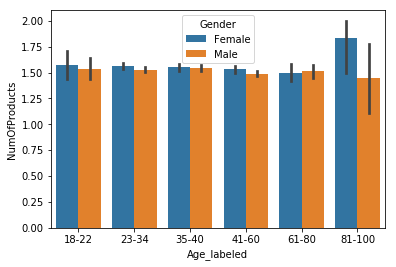

In [14]:
sns.barplot(x='Age_labeled',y='NumOfProducts',hue='Gender', data = all_data)

查看年龄段，性别与退出银行服务的关系，从下图可以看出，不管男女, 几乎都在41-80岁之间退出银行服务，而且其中女性退出的概率大于男性，且与年龄段无关  
Check how Age, Gender related to 'Exited', the chart below show that no matter male or female, if people intend to exit, most of them will do this between 41-80 years old. Also, number of female exit is more that of male.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


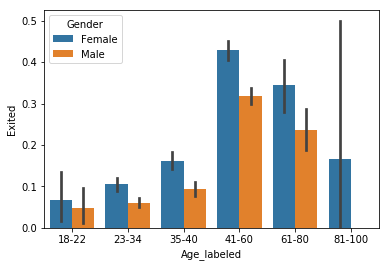

In [15]:
sns.barplot(x = 'Age_labeled',y='Exited',hue='Gender',data=all_data)

In [16]:
dummy_age=pd.get_dummies(all_data['Age_labeled'],prefix='Age')

## 处理信用评分等级，按照FICO标准  
## Split credit score into 5 sections, based on FICO standard

分数区间	评级	
300-579	Very Poor	
580-669	Fair	
670-739	Good	
740-799	Very Good	
800-850	Exceptional	

300-579：很低，表示你是一个非常有风险的客户，一般是信用报告上有非常严重的欠债问题  
580-669：较低，报告上可能有一些风险因素，比如late payments较多  
670-739：平均，大部分人的分数区间，一般来说在这个范围内就不用担心啥了  
740-799：很好，信用记录很不错  
800-850：极好，这种信用分申卡来一张秒一张的感觉~  

In [17]:
bins =[300,579,669,739,799,850]
labels =['Very Poor','Fair','Good','Very Good','Exceptional']
dummy_crdscore_labels=pd.cut(all_data['CreditScore'],bins,labels=labels)
all_data['CreditScore_labled']= dummy_crdscore_labels
dummy_creditscore = pd.get_dummies(all_data['CreditScore_labled'], prefix = 'CreditLevel')

从下图可以看出，无论男女，处于信用中段的客户退出的概率较低，可能是因为太低的无心留恋，而很高的则可能面临其他金融服务的诱惑或者其它因素  
From the chart below, people who have Good credit score are more intend to stay with the bank

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


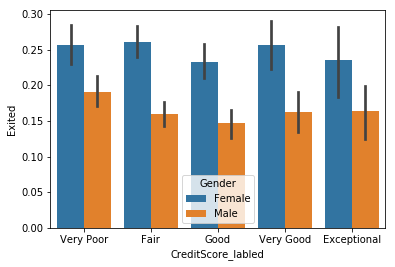

In [18]:
sns.barplot(x = 'CreditScore_labled',y='Exited',hue='Gender',data=all_data)

当前单位工作年限 Tenure 处理，分成1，5，8，10及以上, 数据里10是最大了，所以随便取一个最大值11  
Splie Tenure into 4 section, according to bank standard

In [19]:
bins = [0,1,5,8,11]
labels = ['0-1','1-5','5-8','8-11']
dummy_tenure_labels=pd.cut(all_data['Tenure'],bins,labels=labels,right=False)
all_data['Tenure_labeled']= dummy_tenure_labels
dummy_tenure = pd.get_dummies(all_data['Tenure_labeled'],prefix = 'Tenure')

从下图则可以看出，随着工作年龄的增加，退出银行服务的比例会降低，这点对男性来讲更加确定，但是奇怪的是，女性的比例有点点上升  
From the chat below, we can find with the tenure increasing, people are more intend to stay with bank, especially for male

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


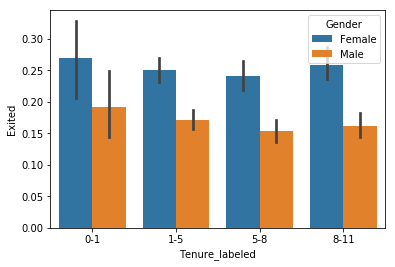

In [20]:
sns.barplot(x = 'Tenure_labeled',y='Exited',hue='Gender',data=all_data)

把银行存款余额与薪水标准化处理  
Standardize Balance and EstimatedSalary

In [21]:
from sklearn.preprocessing import StandardScaler
all_data['Balance'] = StandardScaler().fit_transform(all_data.filter(['Balance']))
all_data['EstimatedSalary'] = StandardScaler().fit_transform(all_data.filter(['EstimatedSalary']))

合并所有处理好的列，并删除原有的列  
Combine all prepared columns and drop original ones

In [22]:
data_combined = pd.concat([
    all_data, dummy_age, dummy_tenure, dummy_creditscore, dummy_geo,
    dummy_gender, dummy_NoOfProducts
],
                          axis=1)

In [23]:
data_combined.drop(
    ['Gender', 'Age', 'CreditScore', 'Geography', 'NumOfProducts', 'Tenure'],
    axis=1,
    inplace=True)

In [24]:
data_combined.drop([
    'Surname', 'CustomerId', 'Age_labeled', 'CreditScore_labled',
    'Tenure_labeled'
],
                   axis=1,
                   inplace=True)

查看下最后的数据，现在所有分类类型都做了热独化，数字类型的比如余额和薪水估值都做了归一化

In [25]:
data_combined.head()

,RowNumber,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_18-22,Age_23-34,Age_35-40,Age_41-60,Age_61-80,Age_81-100,Tenure_0-1,Tenure_1-5,Tenure_5-8,Tenure_8-11,CreditLevel_Very Poor,CreditLevel_Fair,CreditLevel_Good,CreditLevel_Very Good,CreditLevel_Exceptional,Geo_France,Geo_Germany,Geo_Spain,Gender_Female,Gender_Male,NOP_1,NOP_2,NOP_3,NOP_4
0,1,-1.225848,1,1,0.021886,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0
1,2,0.117350,0,1,0.216534,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0
2,3,1.333053,1,0,0.240687,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0
3,4,-1.225848,0,0,-0.108918,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,5,0.785728,1,1,-0.365276,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0


In [26]:
#获取标签值 
#Label value
y_label=data_combined['Exited']
y_label.shape

(10000,)

In [27]:
#去掉标签值，保留训练特征
#Remove lable value, keep training featurers only.
data_combined.drop(['Exited'],axis=1, inplace = True)

In [28]:
X_data = data_combined

In [29]:
#把数据划分出训练集和测试集
#Split data into trainging set and testing set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_data,y_label,test_size=0.2,random_state=2)

使用网格搜索找出随机森林的合适超参数  
Use grid search to find best super parameter for random forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'n_estimators': [50, 100, 150],
        'max_leaf_nodes':[50,100,150]
    },
    {
        'bootstrap': [False],
        'n_estimators': [50, 100,150],
    },
]
churn_mdl_rf_sm = RandomForestClassifier()
grid_search = GridSearchCV(
    churn_mdl_rf_sm, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [50, 100, 150], 'max_leaf_nodes': [50, 100, 150]}, {'bootstrap': [False], 'n_estimators': [50, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [31]:
#查看最佳参数
#Check the best parameters
grid_search.best_params_

{'max_leaf_nodes': 150, 'n_estimators': 150}

In [32]:
#使用最佳参数建立分类器
#Use the best parameters for the classifier
churn_mdl_rf = RandomForestClassifier(
    random_state=2,
    n_estimators=150,
    n_jobs=4,
    max_leaf_nodes=150
)
churn_mdl_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=150,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

使用交叉验证来评估模型,可以看出平均准确度在85%左右  
Use cross validate to evaluate the model，accuracy is about 85%

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(churn_mdl_rf,x_train, y_train,cv=5)

array([0.85758901, 0.855625  , 0.85375   , 0.84625   , 0.8492808 ])

测试集的交叉验证结果  
Cross validation by using testing dataset

In [34]:
cross_val_score(churn_mdl_rf,x_test, y_test,cv=5)

array([0.83541147, 0.85286783, 0.8375    , 0.84711779, 0.84210526])

对整个数据集的交叉验证  
Cross validation by using the whole dataset

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(churn_mdl_rf,X_data, y_label,cv=5)

array([0.85107446, 0.85657171, 0.8485    , 0.85042521, 0.83291646])